In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
import chart_studio.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

import warnings
warnings.filterwarnings('ignore')


Using TensorFlow backend.


# Explore the dataset

In [2]:
df = pd.read_csv('sentence_2_organs.csv')
df.head(20)

,id,sentence,organ
0,1,ГЛАВА и ШИЯ-с нормална конфигурация,глава
1,2,Щитовидна жлеза с меко еластична консистенция...,щитовидна жлеза
2,3,ЕЗИК-необложен,език
3,4,"ГЪРЛО-спокойно, незачервено",гърло
4,5,БЯЛ ДРОБ-чисто везикуларно дишане,бял дроб
5,6,СЪРЦЕ-ритмична сърдечна дейност акц А2,сърце
6,7,ПУЛС-74,пулс
7,8,RR-130/80,кръвно налягане
8,9,"БЯЛ ДРОБ-везикуларно дишане, сухи свиркащи хри...",бял дроб
9,10,SUCC.REN:--,бъбрек


In [3]:
df.organ.value_counts()

бял дроб                    2095
кръвно налягане             1722
сърце                       1496
крайници                     845
корем                        544
кожа                         540
черен дроб                   511
специален статус             449
опорно-двигателен апарат     449
общо състояние               400
бъбрек                       386
гърло                        361
пулс                         355
щитовидна жлеза              300
око                          289
глава                        271
език                         222
лимфни възли                 213
млечна жлеза                 197
температура                  172
тегло                        163
ухо                          122
нервна система               106
ръст                         104
гърди                         47
гръден кош                    23
вена                          14
слезка                         4
ръка                           2
коремна кухина                 1
Name: orga

In [4]:
df['organ'].value_counts()[df['organ'].value_counts()> 100]

бял дроб                    2095
кръвно налягане             1722
сърце                       1496
крайници                     845
корем                        544
кожа                         540
черен дроб                   511
специален статус             449
опорно-двигателен апарат     449
общо състояние               400
бъбрек                       386
гърло                        361
пулс                         355
щитовидна жлеза              300
око                          289
глава                        271
език                         222
лимфни възли                 213
млечна жлеза                 197
температура                  172
тегло                        163
ухо                          122
нервна система               106
ръст                         104
Name: organ, dtype: int64

In [5]:
labels = sorted(df['organ'].unique())
print(labels)

['бъбрек', 'бял дроб', 'вена', 'глава', 'гръден кош', 'гърди', 'гърло', 'език', 'кожа', 'корем', 'коремна кухина', 'крайници', 'кръвно налягане', 'лимфни възли', 'млечна жлеза', 'нервна система', 'общо състояние', 'око', 'опорно-двигателен апарат', 'пулс', 'ръка', 'ръст', 'слезка', 'специален статус', 'сърце', 'тегло', 'температура', 'ухо', 'черен дроб', 'щитовидна жлеза']


In [6]:
#plt.figure(figsize=(16,4))
#df.organ.value_counts().plot(kind='bar');



df['organ'].value_counts().sort_values(ascending=False).iplot(kind='bar', yTitle='Number of sentences', 
                                                                title='Number of sentences in each organ')

# LSTM Modeling

In [7]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['sentence'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 3929 unique tokens.


## Truncate and pad the input sequences so that they are all in the same length for modeling.

In [8]:
X = tokenizer.texts_to_sequences(df['sentence'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (12403, 250)


## Converting categorical labels to numbers.

In [9]:
Y = pd.get_dummies(df['organ']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (12403, 30)


## Train test split.

In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(11162, 250) (11162, 30)
(1241, 250) (1241, 30)


## Model Train

In [11]:
classes_number = np.count_nonzero(labels)

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(classes_number, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 10045 samples, validate on 1117 samples
Epoch 1/5
10045/10045 [==============================] - 58s 6ms/step - loss: 2.2411 - accuracy: 0.4006 - val_loss: 1.0385 - val_accuracy: 0.7431
Epoch 2/5
10045/10045 [==============================] - 57s 6ms/step - loss: 0.5153 - accuracy: 0.8934 - val_loss: 0.1833 - val_accuracy: 0.9722
Epoch 3/5
10045/10045 [==============================] - 56s 6ms/step - loss: 0.1372 - accuracy: 0.9789 - val_loss: 0.0951 - val_accuracy: 0.9821
Epoch 4/5
10045/10045 [==============================] - 57s 6ms/step - loss: 0.0766 - accuracy: 0.9873 - val_loss: 0.0720 - val_accuracy: 0.9848
Epoch 5/5
10045/10045 [==============================] - 56s 6ms/step - loss: 0.0524 - accuracy: 0.9906 - val_loss: 0.0641 - val_accuracy: 0.9830


In [12]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1241/1241 [==============================] - 2s 2ms/step
Test set
  Loss: 0.099
  Accuracy: 0.979


## Loss

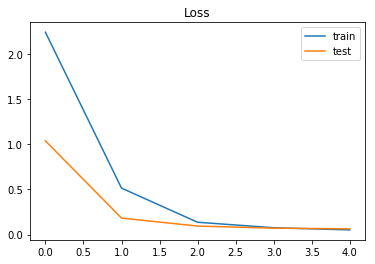

In [13]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

## Accuracy

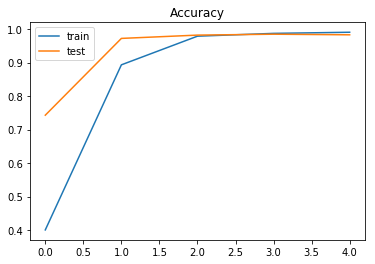

In [14]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

# Test with new Sentence

In [36]:
new_sentence = ['СЪРЦЕ-ритм сърд д-ст ясни тонове  акцА2 на Ао  и или слаб сист  шум; RR-145/85']
seq = tokenizer.texts_to_sequences(new_sentence)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
print(pred, labels[np.argmax(pred)])

[[1.01944033e-05 1.30484314e-05 1.14971705e-07 7.98874282e-07
  2.35132052e-06 5.32071363e-06 7.87667450e-05 2.96032056e-07
  7.74493856e-06 4.70769646e-06 6.96007163e-08 6.91970001e-08
  1.28003536e-04 3.09151619e-06 7.07813706e-06 4.48950210e-08
  1.95197615e-07 7.70215422e-07 3.03207662e-06 6.74316470e-05
  3.06544706e-07 1.70354531e-06 2.58050875e-07 5.68548276e-05
  9.99569714e-01 2.58097259e-08 2.05766219e-06 1.16884701e-06
  9.63719231e-07 3.38777027e-05]] сърце
